In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load dataset
rating = pd.read_csv("ml-25m/ratings.csv")
movie = pd.read_csv("ml-25m/movies.csv")
link = pd.read_csv("ml-25m/links.csv")

In [3]:
print("="*50)
print("THỐNG KÊ DỮ LIỆU")
print("="*50)
print(f"Ratings: {rating.shape[0]} đánh giá, {rating['userId'].nunique()} người dùng")
print(f"Movies: {movie.shape[0]} phim")

THỐNG KÊ DỮ LIỆU
Ratings: 25000095 đánh giá, 162541 người dùng
Movies: 62423 phim


In [4]:
rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
link.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


# Phân tích khám phá dữ liệu (EDA)

**Biểu đồ tần suất theo điểm đánh giá**

C:\Users\QuynhAnh\AppData\Local\Temp\ipykernel_19596\1540595486.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rating, x='rating', palette='Set2')


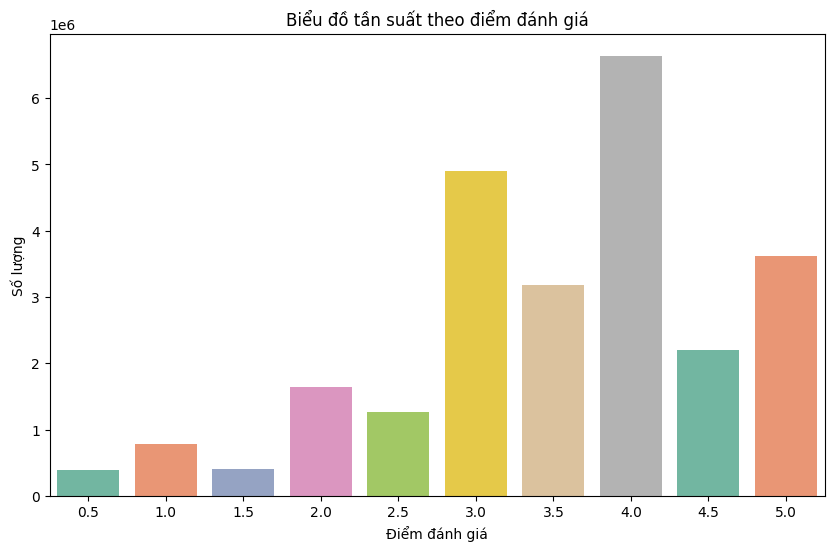

In [ ]:
# Vẽ biểu đồ 
plt.figure(figsize=(10, 6))
sns.countplot(data=rating, x='rating', palette='Set2')
plt.title('Biểu đồ tần suất theo điểm đánh giá')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Số lượng')
plt.show()

## Phân tích theo phim

**Top 20 bộ phim có số lượt đánh giá nhiều nhất**

C:\Users\QuynhAnh\AppData\Local\Temp\ipykernel_19596\546681848.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='title', x='num_ratings', data=top_movies, palette='viridis')


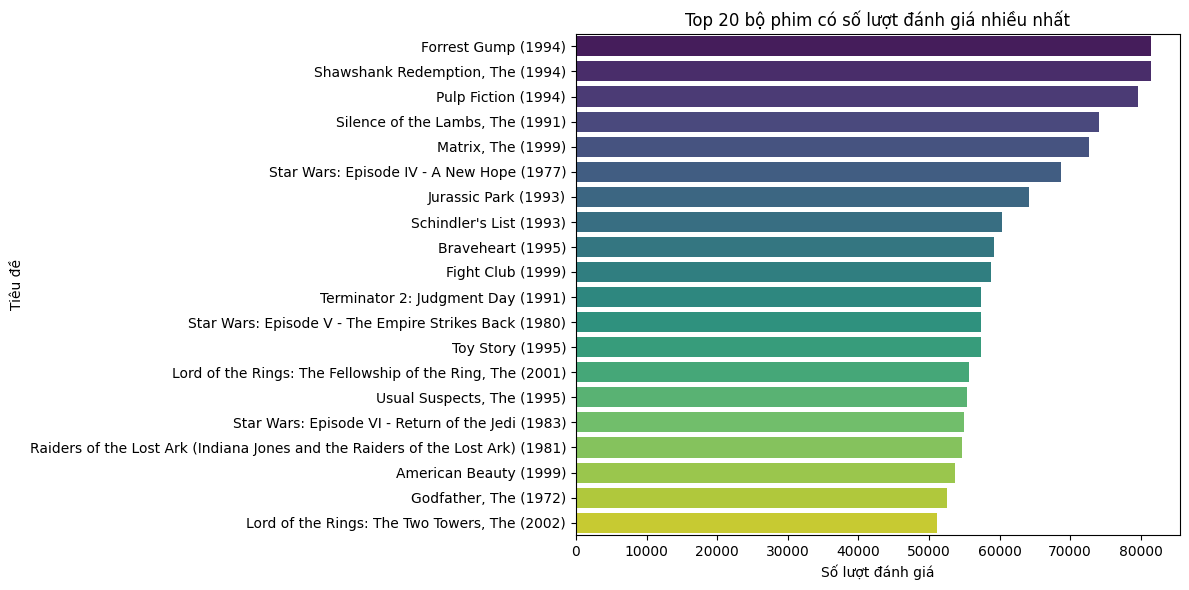

In [10]:
# Lấy danh sách 20 bộ phim có số lượt đánh giá cao nhất
top_movies = rating['movieId'].value_counts().head(20)
# Tạo DataFrame 
top_movies = pd.DataFrame({'movieId': top_movies.index, 'num_ratings': top_movies.values})
# Gộp dữ liệu với bảng 'movie' để lấy tên phim
top_movies = top_movies.merge(movie[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(y='title', x='num_ratings', data=top_movies, palette='viridis')
plt.title('Top 20 bộ phim có số lượt đánh giá nhiều nhất')
plt.xlabel('Số lượt đánh giá')
plt.ylabel('Tiêu đề')
plt.tight_layout()
plt.show()

**Top 20 bộ phim có điểm trung bình cao nhất**

C:\Users\QuynhAnh\AppData\Local\Temp\ipykernel_13528\3399569490.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='title', data=top_rated, palette='viridis')


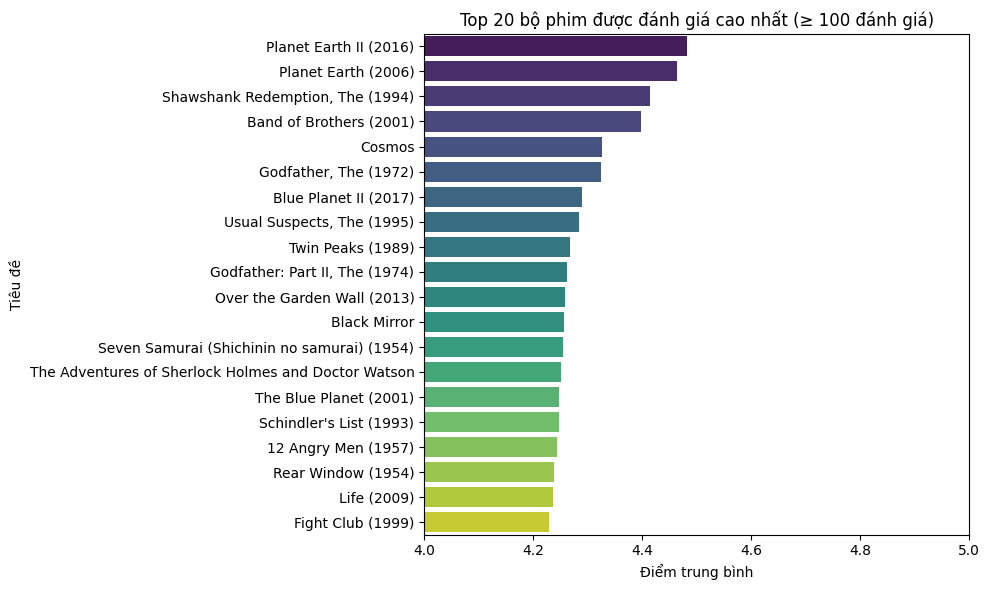

In [3]:
# Tính điểm trung bình và số lượt đánh giá cho từng phim
movie_stats = rating.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

# Lọc các bộ phim có ít nhất 100 đánh giá
popular_movies = movie_stats[movie_stats['rating_count'] >= 100]
# Lấy 20 bộ phim có điểm trung bình cao nhất
top_rated = popular_movies.sort_values(by='avg_rating', ascending=False).head(20)
# Gộp với bảng 'movie' để lấy title của phim
top_rated = top_rated.merge(movie[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_rating', y='title', data=top_rated, palette='viridis')
plt.title('Top 20 bộ phim được đánh giá cao nhất (≥ 100 đánh giá)')
plt.xlabel('Điểm trung bình')
plt.ylabel('Tiêu đề')
plt.xlim(4, 5)
plt.tight_layout()
plt.show()

## Phân tích theo thể loại

In [ ]:
# Nối dữ liệu từ bảng 'rating' và 'movie'
merged = rating.merge(movie, on='movieId')
# Loại bỏ các bộ phim không có thể loại
merged = merged[merged['genres'] != '(no genres listed)']
# Tách các thể loại thành list rồi tách thành các dòng riêng biệt
merged['genres'] = merged['genres'].str.split('|')
exploded = merged.explode('genres')
exploded.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy
0,1,296,5.0,1147880044,Pulp Fiction (1994),Crime
0,1,296,5.0,1147880044,Pulp Fiction (1994),Drama
0,1,296,5.0,1147880044,Pulp Fiction (1994),Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama


**Biểu đồ phân phối của thể loại phim**

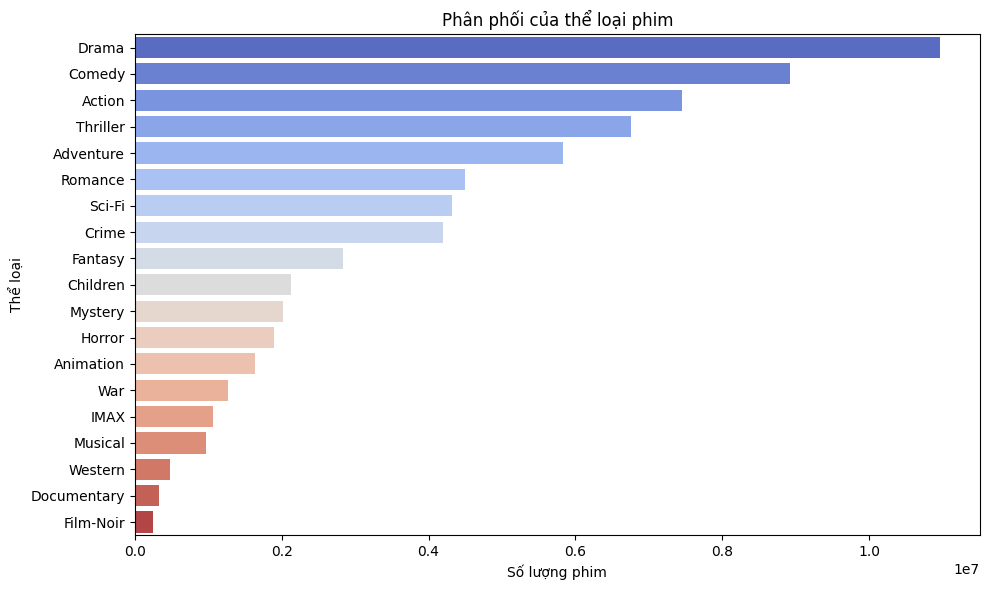

In [ ]:
# Đếm số lượng phim theo từng thể loại
genre_counts = exploded['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts, x='count', y='genre', palette='coolwarm')
plt.title('Phân phối của thể loại phim')
plt.xlabel('Số lượng phim')
plt.ylabel('Thể loại')
plt.tight_layout()
plt.show()

**Biểu đồ cho thấy trung bình điểm đánh giá theo thể loại**

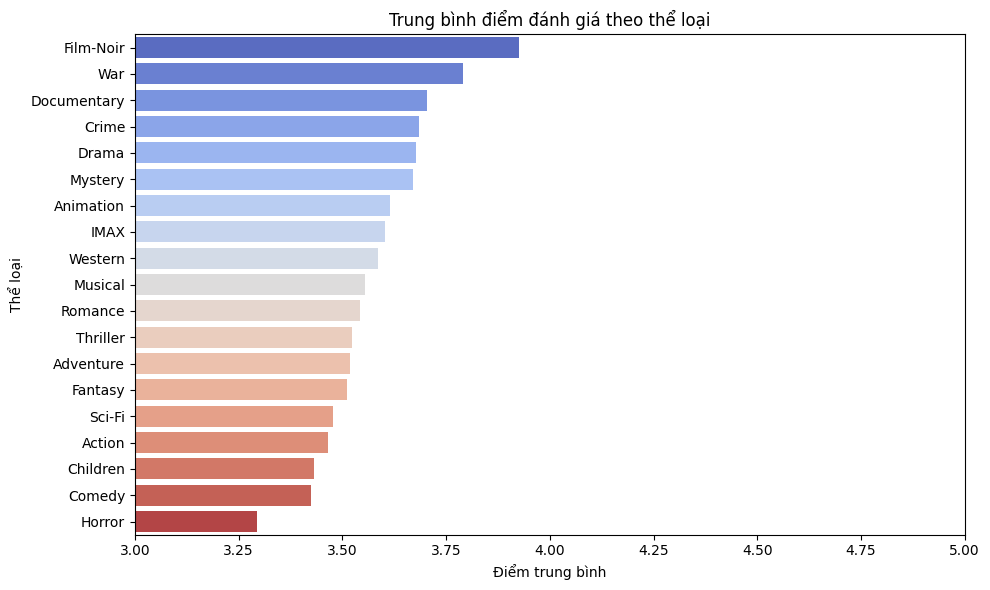

In [ ]:
# Tính trung bình điểm đánh giá theo thể loại phim
genre_avg = exploded.groupby('genres')['rating'].mean().reset_index()
genre_avg.columns = ['genre', 'avg_rating']
# Sắp xếp điểm trung bình từ cao đến thấp
genre_avg = genre_avg.sort_values(by='avg_rating', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_avg, x='avg_rating', y='genre', palette='coolwarm')
plt.title('Trung bình điểm đánh giá theo thể loại')
plt.xlabel('Điểm trung bình')
plt.ylabel('Thể loại')
plt.xlim(3, 5)
plt.tight_layout()
plt.show()

## Phân tích theo thời gian

**Biểu đồ cho thấy số lượng đánh giá theo năm**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


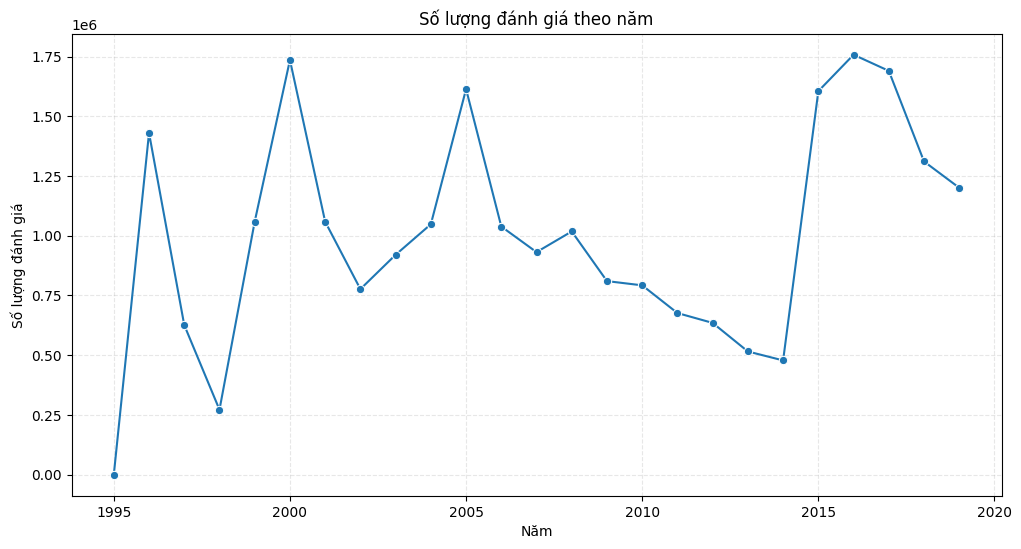

In [ ]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy năm
rating['year'] = pd.to_datetime(rating['timestamp'], unit='s').dt.year
# Đếm số đánh giá theo từng năm
ratings_by_year = rating['year'].value_counts().sort_index()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.lineplot(x=ratings_by_year.index, y=ratings_by_year.values, marker='o')
plt.title('Số lượng đánh giá theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng đánh giá')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

**Biểu đồ heatmap: số lượt đánh giá theo năm và tháng**

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


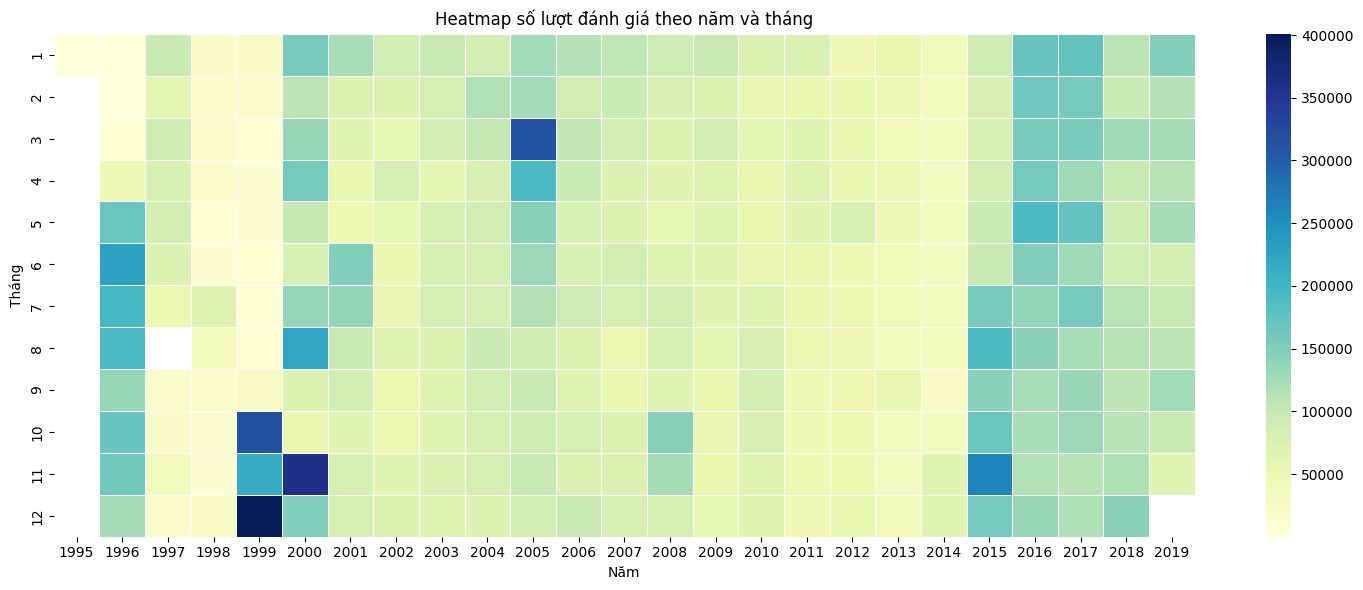

In [ ]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy theo tháng (Year-Month)
rating['year_month'] = pd.to_datetime(rating['timestamp'], unit='s').dt.to_period('M')
# Đếm số lượt đánh giá theo tháng và năm
ratings_heatmap = rating.groupby(rating['year_month']).size().reset_index(name='count')
ratings_heatmap['year'] = ratings_heatmap['year_month'].dt.year
ratings_heatmap['month'] = ratings_heatmap['year_month'].dt.month

# Tạo bảng pivot với tháng là index và năm là cột
pivot_table = ratings_heatmap.pivot(index='month', columns='year', values='count')

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5, annot=False)
plt.title('Heatmap số lượt đánh giá theo năm và tháng')
plt.xlabel('Năm')
plt.ylabel('Tháng')
plt.tight_layout()
plt.show()

**Biểu đồ điểm đánh giá trung bình theo từng tháng qua các năm**

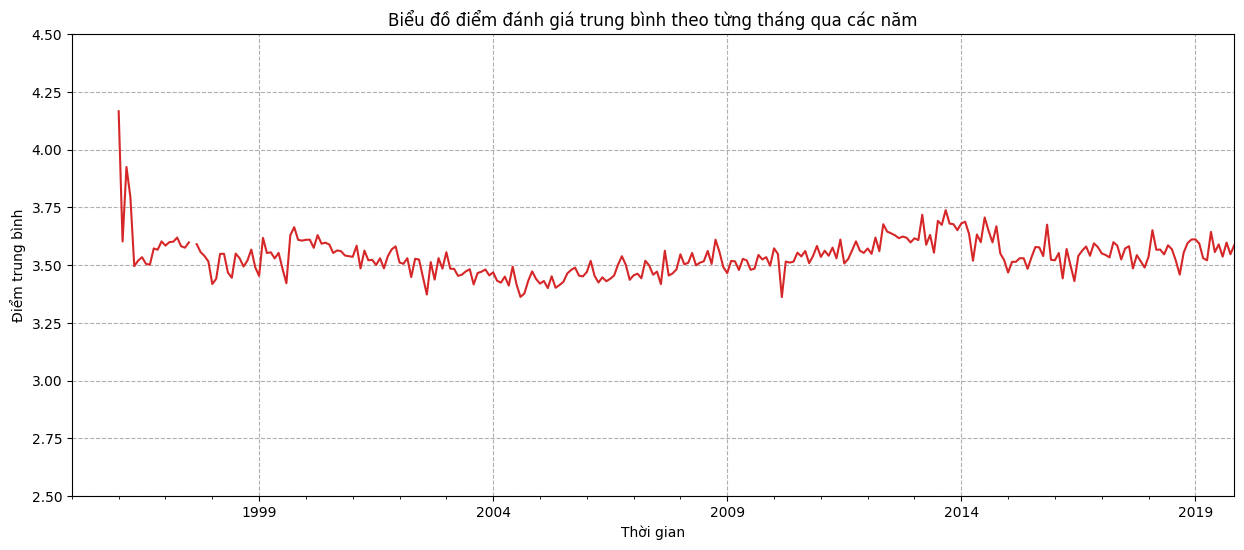

In [ ]:
# Chuyển cột 'timestamp' sang kiểu datetime và gán về ngày
rating['date'] = pd.to_datetime(rating['timestamp'], unit='s')
# Tính điểm trung bình mỗi tháng (resample theo cuối tháng)
rating.set_index('date')['rating'].resample('ME').mean().plot(figsize=(15, 6), color='tab:red')

# Vẽ biểu đồ
plt.title('Biểu đồ điểm đánh giá trung bình theo từng tháng qua các năm')
plt.xlabel('Thời gian')
plt.ylabel('Điểm trung bình')
plt.ylim(2.5, 4.5)
plt.grid(True, linestyle='--')
plt.show()

# Preprocessing

In [ ]:
# Kiểm tra ratings hợp lệ (0.5 đến 5.0)
if (rating['rating'] < 0.5).any() or (rating['rating'] > 5.0).any():
    print("Warning: Invalid rating values detected.")

In [ ]:
# Tính số lượng người dùng, phim và tổng số lượt đánh giá
n_users = rating['userId'].nunique()
n_movies = rating['movieId'].nunique()
n_ratings = len(rating)

# Tính độ thưa (sparsity) của ma trận ratings
sparsity = 1 - n_ratings / (n_users * n_movies)
print(f"\nĐộ thưa của ma trận: {sparsity:.4f} ({n_ratings} ratings / {n_users * n_movies} possible ratings)")


Độ thưa của ma trận: 0.9974 (25000095 ratings / 9597558427 possible ratings)


In [ ]:
# Nối bảng rating với movie để lấy tiêu đề phim
df = pd.merge(rating, movie, on='movieId')

# Mã hóa userId và title thành chỉ số để xây dựng ma trận
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
df['user_idx'] = user_encoder.fit_transform(df['userId'])
df['movie_idx'] = movie_encoder.fit_transform(df['title'])

# Tạo sparse matrix từ rating (dòng: user, cột: movie)
ratings_sparse = csr_matrix((df['rating'], (df['user_idx'], df['movie_idx'])))
ratings_sparse.shape

(162541, 58958)

# Truncated SVD

In [ ]:
def truncated_svd(X, n_components=30):
    """
    Tính Truncated SVD (Singular Value Decomposition) cho ma trận thưa X.

    Tham số:
        X: Ma trận thưa (users x movies)
        n_components: Số lượng thành phần chính (rank giảm chiều)
    
    Các bước thực hiện:
        1. Tính X.T @ X (movies x movies)
        2. Phân tích eigen: lấy top k các trị riêng (eigenvalues) và vector riêng (eigenvectors) lớn nhất
        3. Tính các giá trị kỳ dị (singular values) bằng căn bậc hai của eigenvalues
        4. Tính ma trận U = X @ V / Sigma
        5. Dựng lại ma trận xấp xỉ: X ~ U * Sigma * V^T

    Trả về:
        - X_approx: Ma trận xấp xỉ gốc với rank thấp hơn
    """

    # Bước 1: X.T @ X
    C = X.T.dot(X)

    # Bước 2: Phân tích eigen (chỉ lấy top k)
    eigenvalues, eigenvectors = eigsh(C, k=n_components, which='LM')

    # Bước 3: Sắp xếp các trị riêng theo thứ tự giảm dần
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Bước 4: Tính singular values từ eigenvalues
    Sigma = np.sqrt(eigenvalues)

    # Bước 5: Tính ma trận U
    U = X.dot(eigenvectors)
    U = U / Sigma[np.newaxis, :]

    Vt = eigenvectors.T

    # Step 6: Dựng lại ma trận xấp xỉ
    X_approx = U @ np.diag(Sigma) @ Vt

    return X_approx

In [ ]:
# from scipy.sparse import coo_matrix

# def svd_baseline_predict(ratings_df, user_enc, movie_enc, k=50):
#     """
#     Dự đoán rating bằng phương pháp SVD có chuẩn hóa (phiên bản đơn giản của Iterative SVD) theo người dùng.

#     Tham số:
#         ratings_df: DataFrame chứa các cột ['user_idx', 'movie_idx', 'rating']
#         user_enc, movie_enc: LabelEncoder đã fit
#         k: Số lượng thành phần ẩn (rank giảm chiều)
        
#     Các bước thực hiện:
#         1. Khởi tạo ma trận rating rời rạc từ dữ liệu.
#         2. Tính trung bình rating theo từng hàng (user).
#         3. Mean-center ma trận bằng cách trừ trung bình từng user.
#         4. Áp dụng Truncated SVD để xấp xỉ ma trận chuẩn hóa.
#         5. Cộng lại trung bình user để khôi phục thang điểm ban đầu.

#     Trả về:
#         R_hat: Ma trận dự đoán (users x movies)
#         R: Ma trận gốc ở dạng sparse
#         row_means: Giá trị trung bình rating theo từng user
#     """

#     # Kiểm tra tính hợp lệ của dữ liệu đầu vào
#     required_columns = ['user_idx', 'movie_idx', 'rating']
#     if not all(col in ratings_df.columns for col in required_columns):
#         raise ValueError(f"ratings_df must contain columns: {required_columns}")
#     if ratings_df[required_columns].isnull().any().any():
#         raise ValueError("ratings_df contains NaN values.")

#     ratings_df = ratings_df.copy()

#     n_users = len(user_enc.classes_)
#     n_movies = len(movie_enc.classes_)

#     if k > min(n_users, n_movies):
#         raise ValueError(f"k={k} is too large. Must be <= {min(n_users, n_movies)}")

#     # Bước 1: Tạo sparse matrix từ ratings gốc
#     row = ratings_df['user_idx'].values
#     col = ratings_df['movie_idx'].values
#     data = ratings_df['rating'].values
#     R = coo_matrix((data, (row, col)), shape=(n_users, n_movies))

#     #  Bước 2: Tính trung bình rating theo từng user (row_means)
#     row_sums = np.array(R.sum(axis=1)).flatten()
#     row_counts = np.array((R != 0).sum(axis=1)).flatten()
#     row_means = np.zeros(n_users)
#     mask = row_counts > 0
#     row_means[mask] = row_sums[mask] / row_counts[mask]

#     # Bước 3: Chuẩn hóa ma trận bằng cách trừ trung bình mỗi user (Mean-center)
#     R_centered = R.copy()
#     R_centered.data -= row_means[R_centered.row]

#     # Bước 4: Áp dụng truncated SVD lên ma trận chuẩn hóa
#     U, S, Vt = truncated_svd(R_centered, n_components=k)

#     # Bước 5: Khôi phục lại ma trận dự đoán ban đầu
#     R_hat_centered = U @ np.diag(S) @ Vt
#     R_hat = R_hat_centered + row_means[:, np.newaxis]

#     return R_hat, R, row_means

In [ ]:
# Lọc 500 người dùng đánh giá nhiều nhất
sample_users = df['userId'].value_counts().head(500).index
sample_df = df[df['userId'].isin(sample_users)].copy()

# Mã hóa userId và title thành chỉ số để xây dựng ma trận
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
sample_df['user_idx'] = user_encoder.fit_transform(sample_df['userId'])
sample_df['movie_idx'] = movie_encoder.fit_transform(sample_df['title'])

# Chia dữ liệu thành tập huấn luyện và kiểm tra (train và test)
train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=42)

# Tạo ma trận thưa từ tập train (users x movies)
train_matrix = csr_matrix((train_df['rating'], (train_df['user_idx'], train_df['movie_idx'])),
                          shape=(sample_df['user_idx'].nunique(), sample_df['movie_idx'].nunique()))

# Áp dụng Truncated SVD để giảm chiều
X_approx = truncated_svd(train_matrix, n_components=30)

In [ ]:
def evaluate_metric(df, X_approx):
    """
    Đánh giá chất lượng dự đoán của ma trận xấp xỉ so với rating gốc.

    Tham số:
        df : Chứa các cột ['user_idx', 'movie_idx', 'rating']
        X_approx : Ma trận xấp xỉ

    Trả về:
        rmse : Root Mean Squared Error
        mae  : Mean Absolute Error
    """
    predictions, actuals = [], []

    for _, row in df.iterrows():
        u, m = row['user_idx'], row['movie_idx']
        # Chỉ xét những chỉ số hợp lệ (trong vùng của X_approx)
        if u < X_approx.shape[0] and m < X_approx.shape[1]:
            predictions.append(X_approx[u, m])
            actuals.append(row['rating'])

    # Tính sai số
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae

# Đánh giá trên tập huấn luyện (train)
train_rmse, train_mae = evaluate_metric(train_df, X_approx)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")

# Đánh giá trên tập kiểm tra (test)
test_rmse, test_mae = evaluate_metric(test_df, X_approx)
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train RMSE: 1.8839
Train MAE: 1.5910
Test RMSE: 2.1949
Test MAE: 1.9199
